In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import date
from datetime import datetime
import numpy as np
import pandas as pd

from summer.utils import ref_times_to_dti

from pathlib import Path

from autumn.tools.inputs.demography.queries import get_population_by_agegroup
from autumn.models.covid_19.detection import create_cdr_function
from autumn.tools.utils.utils import apply_moving_average
from autumn.tools.curve.scale_up import scale_up_function
from autumn.tools.project import get_project
from autumn.settings import INPUT_DATA_PATH, Region, Models
from autumn.models.covid_19.constants import AGEGROUP_STRATA, GOOGLE_MOBILITY_LOCATIONS
from autumn.models.covid_19.mixing_matrix.macrodistancing import weight_mobility_data, get_mobility_data
from autumn.settings.constants import COVID_BASE_DATETIME
from autumn.tools import inputs
from autumn.tools.inputs.database import get_input_db
from autumn.tools.utils.pretty import pretty_print
from autumn.tools.inputs.social_mixing.build_synthetic_matrices import build_synthetic_matrices
from autumn.models.covid_19.detection import get_testing_numbers_for_region



In [54]:
plt.style.use("ggplot")

In [71]:
from autumn.projects.sm_sir.bhutan.bhutan import project

In [72]:
def convert_ts_index_to_date(ts):
    ts.index = ref_times_to_dti(COVID_BASE_DATETIME, ts.index)
    return ts

In [73]:
ts_sets = project.ts_set
ts_set_dates = {k: convert_ts_index_to_date(v) for k, v in ts_sets.items()}


In [74]:
ts_set_dates

{'notifications': 2020-03-05       1
 2020-03-19       1
 2020-03-25       1
 2020-03-28       1
 2020-04-01       1
               ... 
 2022-04-20    1024
 2022-04-21     686
 2022-04-22     302
 2022-04-23     737
 2022-04-24     431
 Name: notifications, Length: 468, dtype: int64,
 'prevalence_infectious': 2020-01-25    7.0
 2020-01-30    5.0
 Name: prevalence_infectious, dtype: float64,
 'icu_occupancy': Series([], Name: icu_occupancy, dtype: float64),
 'hospital_occupancy': Series([], Name: hospital_occupancy, dtype: float64),
 'infection_deaths': Series([], Name: infection_deaths, dtype: float64),
 'proportion_seropositive': Series([], Name: proportion_seropositive, dtype: float64),
 'cdr': Series([], Name: cdr, dtype: float64)}

In [75]:
model_name = 'sm_sir'
region = 'bhutan'

project = get_project(model_name, region, reload=True)
base_params = project.param_set.baseline

total modelled population of bhutan is: 763.247 thousand


Text(0.5, 0.98, 'population distribution by age')

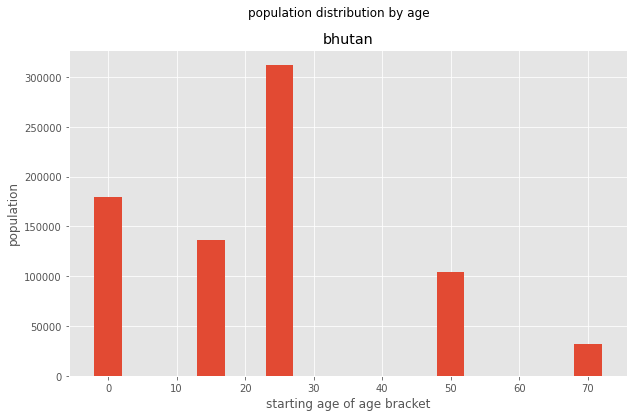

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
age_groups = base_params["age_groups"]

total_pops = inputs.get_population_by_agegroup(
    age_groups, 
    base_params["country"]["iso3"],
    None,
#     "FDMN", 
    year=base_params["population"]["year"]
)
print(f"total modelled population of {region} is: {round(sum(total_pops) / 1e3, 3)} thousand")
ax.bar(age_groups, total_pops, width=4)
ax.set_title(region)
ax.set_ylabel("population")
ax.set_xlabel("starting age of age bracket")
fig.suptitle("population distribution by age")

In [77]:
mob_df = get_mobility_data("BTN", region=None,base_date = COVID_BASE_DATETIME )[0]
times = mob_df["date"].to_list()
google_mob_df = weight_mobility_data(mob_df, project.param_set.baseline["mobility"]["google_mobility_locations"])

In [78]:
mob_df

,date,date_index,tiles_visited,single_tile,iso3,region,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,2020-03-01,61,0.968319,0.158795,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,62,0.966102,0.147343,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,63,0.975920,0.154181,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,64,1.011673,0.147913,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,65,1.020682,0.142365,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
786,2022-04-26,847,0.938480,0.170924,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
787,2022-04-27,848,0.946308,0.160858,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,2022-04-28,849,0.913348,0.153236,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789,2022-04-29,850,0.890046,0.150080,BTN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18262.0, 19112.0)

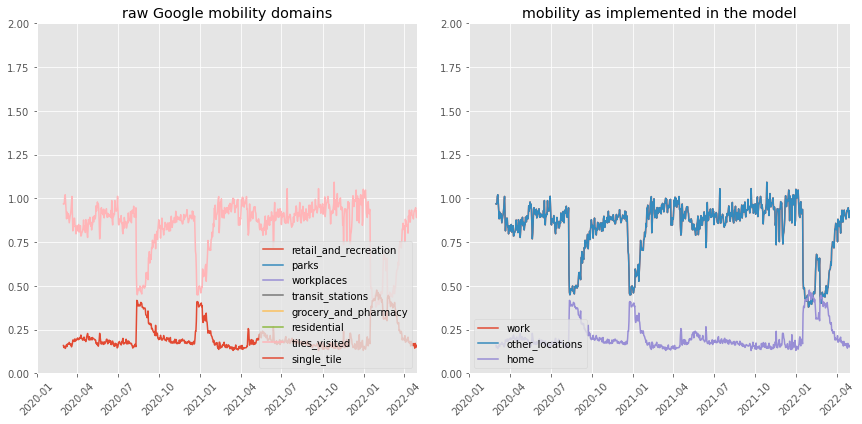

In [79]:
y_upper = 2.
mob_fig, mob_axes = plt.subplots(1, 2, figsize=(12, 6))
plot_left_date = date(2020, 1, 1)
plot_right_date = times[-1]  # Not sure why this is necessary

# Plot raw mobility data
ax = mob_axes[0]
for mobility_domain in GOOGLE_MOBILITY_LOCATIONS:
    ax.plot(times, mob_df[mobility_domain], label=mobility_domain)
ax.set_ylim((0., y_upper))
ax.tick_params(axis="x", labelrotation=45)
ax.set_title("raw Google mobility domains")
ax.legend(loc="lower right")
ax.set_xlim(left=plot_left_date, right=plot_right_date)

# Plot processed mobility data
ax = mob_axes[1]
for location in list(project.param_set.baseline["mobility"]["google_mobility_locations"].keys()):
    ax.plot(times, google_mob_df[location], label=location)
ax.tick_params(axis="x", labelrotation=45)
ax.set_ylim((0., y_upper))
ax.legend(loc="lower left")
ax.set_title("mobility as implemented in the model")
mob_fig.tight_layout(w_pad=1.5, h_pad=3.5)
ax.set_xlim(left=plot_left_date, right=plot_right_date)

In [80]:
print(f"Modelled country: {project.param_set.baseline['country']['iso3']}")
print(f"Modelled sub-region: {project.param_set.baseline['population']['region']}")
print(f"Proxy country: {project.param_set.baseline['ref_mixing_iso3']}")
print("Always age-adjusted under SM-SIR code")

Modelled country: BTN
Modelled sub-region: None
Proxy country: CHN
Always age-adjusted under SM-SIR code


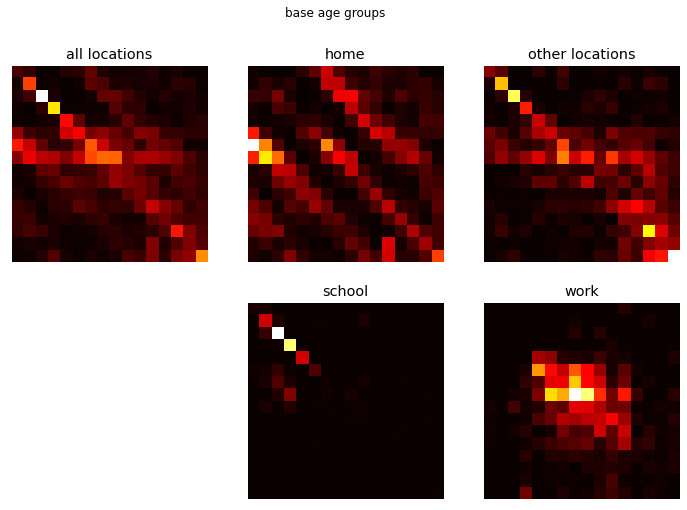

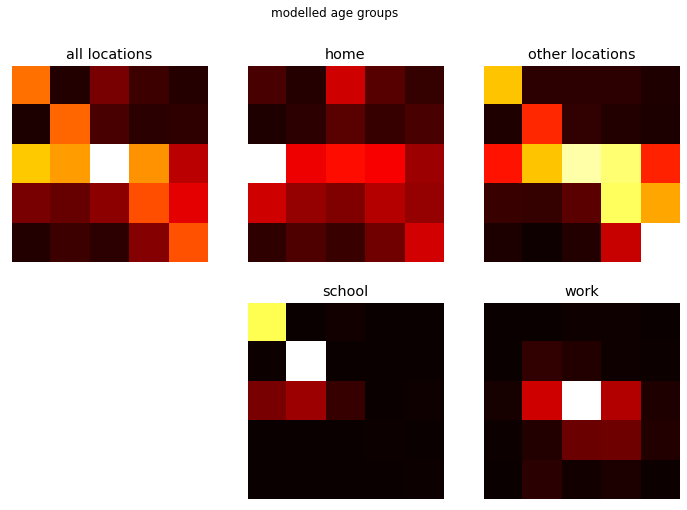

In [65]:
agegroup_types = {
    "base age groups": AGEGROUP_STRATA,
    "modelled age groups": project.param_set.baseline["age_groups"],
}

for title, agegroups in agegroup_types.items():

    mixing_matrix = build_synthetic_matrices(
        project.param_set.baseline["country"]["iso3"],
        project.param_set.baseline["ref_mixing_iso3"],
        agegroups,
        True,
        project.param_set.baseline["population"]["region"]
    )

    fig = plt.figure(figsize=(12, 8))
    positions =  [1, 2, 3, 5, 6]
    for i_loc, location in zip(positions, mixing_matrix.keys()):
        ax = fig.add_subplot(2, 3, i_loc)
        ax.imshow(
            np.flipud(np.transpose(mixing_matrix[location])), 
            cmap=cm.hot, 
            vmin=0,
            vmax=mixing_matrix[location].max(), 
            origin="lower"
        )
        ax.set_title(location.replace("_", " "))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(title)

In [81]:
project = get_project("sm_sir", "bhutan", reload=True)
baseline_params = project.param_set.baseline
model = project.run_baseline_model(baseline_params)
baseline_df = model.get_derived_outputs_df()
model_start_time = ref_times_to_dti(COVID_BASE_DATETIME, [baseline_params["time"]["start"]])[0]

In [82]:
sc_models = project.run_scenario_models(model, project.param_set.scenarios)
scenario_dfs = [m.get_derived_outputs_df() for m in sc_models]

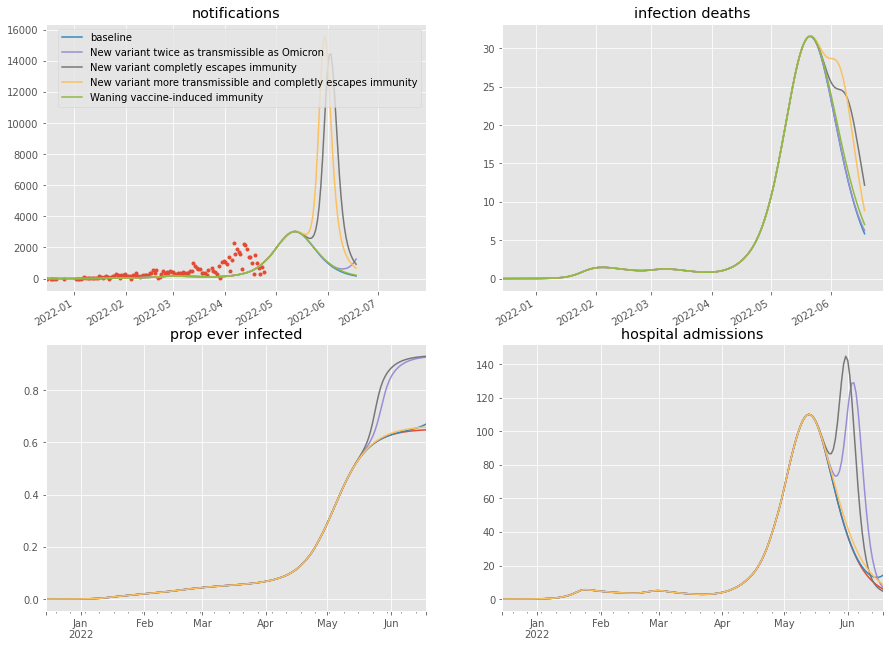

In [83]:
outputs_to_plot = ["notifications", "infection_deaths", "prop_ever_infected", "hospital_admissions"]
plot_end_time = ref_times_to_dti(COVID_BASE_DATETIME, [1000.])[0]

fig = pyplot.figure(figsize=(15, 12))
for i_out, output in enumerate(outputs_to_plot):
    axis = fig.add_subplot(2, 2, i_out + 1)
    
    # Plotting
    if output in ts_set_dates:
        ts_set_dates[output].plot(style='.', label="")
    baseline_df[output].plot(label="baseline")
    for scenario in range(len(sc_models)):
        scenario_dfs[scenario][outputs_to_plot[i_out]].plot(label=project.param_set.scenarios[scenario]["description"])

    # Display
    axis.set_title(output.replace("_", " "))
    if i_out == 0:
        axis.legend()
    axis.set_xlim(left=model_start_time)